In [1]:
library(Cardinal)
library(yaml)

Loading required package: ProtGenerics


Attaching package: ‘ProtGenerics’


The following object is masked from ‘package:stats’:

    smooth


Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, table,
    tapply, union, unique, unsplit, which.max, which.min


Loading required package: BiocParallel

Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are

In [2]:
# Read the hyperparameters from the config file
config <- read_yaml("workspace/config.yml")

# Hyperparameters
lame <- config$lame
signal_to_noise <- config$signal_to_noise

# Path to the data and results
path <- sprintf("%s/%s", config$path_to_data, lame)

Warning message in readLines(file, warn = readLines.warn):
“incomplete final line found on 'workspace/config.yml'”


In [3]:
# Load the detected peaks imzml file
mse_peaks <- readMSIData(sprintf("%s/results/mse_densities.imzML", path))

# Change the data centroided attribute to TRUE
centroided(mse_peaks) <- TRUE

mse_peaks

MSImagingExperiment with 5742 features and 189978 spectra 
spectraData(1): intensity
featureData(3): mz, count, freq
pixelData(16): x, y, run, ..., Density_CD8, Density_Tumor, Density_Stroma
coord(2): x = 1...567, y = 1...410
runNames(1): 12AG01290_19
experimentData(11): spectrumType, spectrumRepresentation, instrumentModel, ..., scanType, lineScanDirection, pixelSize
mass range:  500.2861 to 3599.6222 
centroided: TRUE 

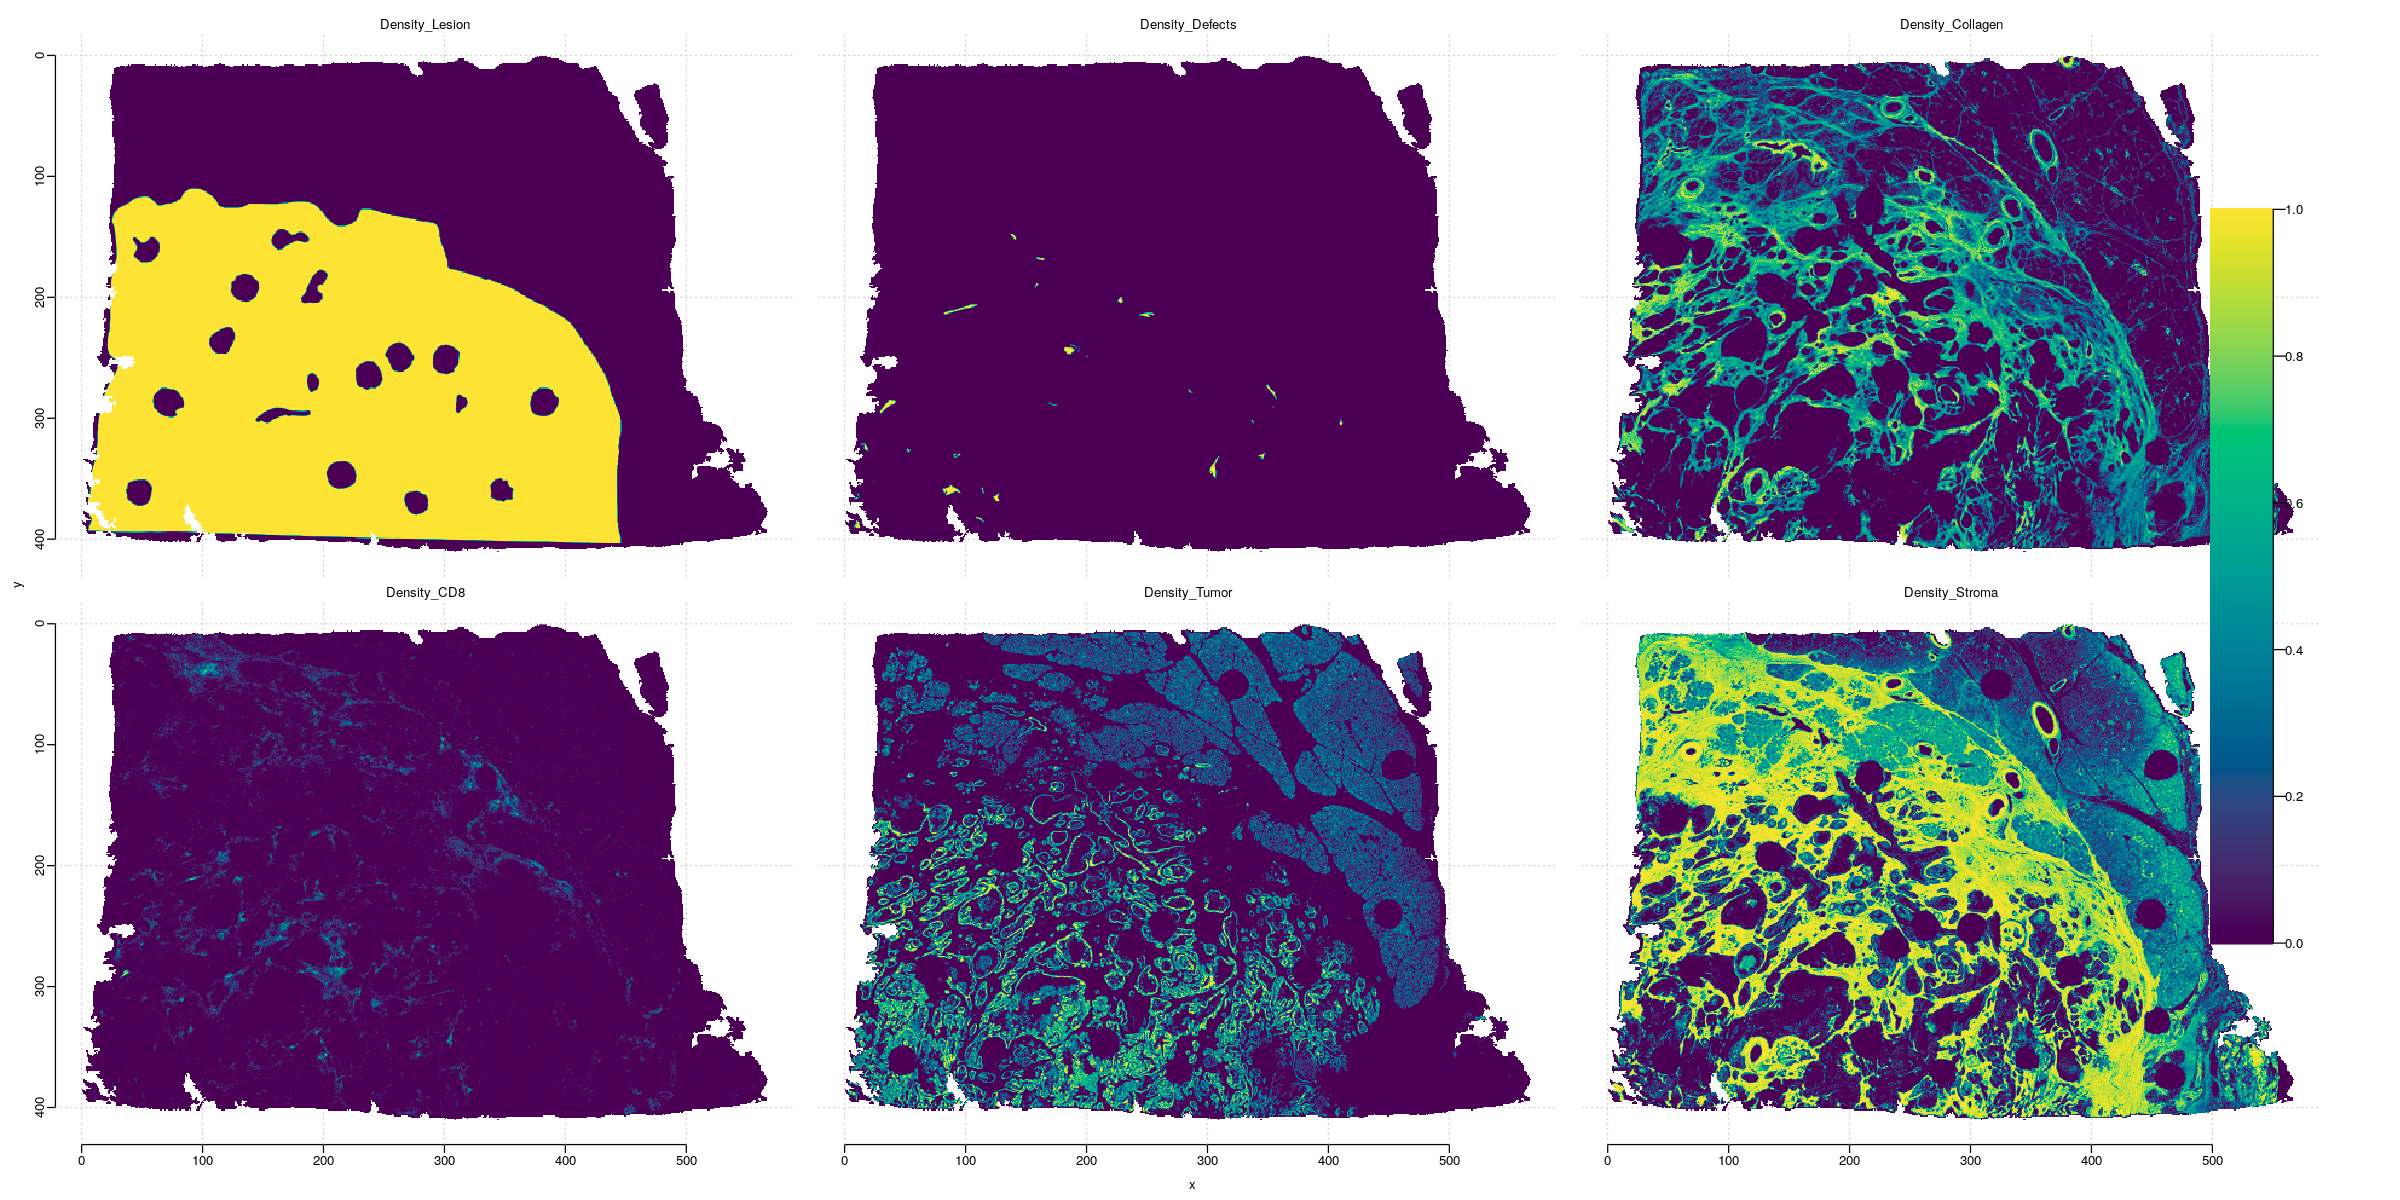

In [4]:
# Visualize the IHC features
options(repr.plot.width = 20, repr.plot.height = 10)
image(mse_peaks,
      grep("Density", colnames(pData(mse_peaks)), value = TRUE),
      layout = c(2, 3), )

In [35]:
# Cut the data to a small balanced region
fid <- features(mse_peaks, freq > 0.05)
pid <- pixels(mse_peaks,
              10 < x, x < 450,
              100 < y, y < 450,
              Density_Lesion > 0.9,
              Density_Defects < 0.1,
              run == config$lame)

mse_subset <- mse_peaks[fid, pid]
mse_subset

MSImagingExperiment with 817 features and 95492 spectra 
spectraData(1): intensity
featureData(3): mz, count, freq
pixelData(16): x, y, run, ..., Density_CD8, Density_Tumor, Density_Stroma
coord(2): x = 11...445, y = 111...403
runNames(1): 12AG01290_19
experimentData(11): spectrumType, spectrumRepresentation, instrumentModel, ..., scanType, lineScanDirection, pixelSize
mass range:  501.2959 to 3596.8128 
centroided: TRUE 

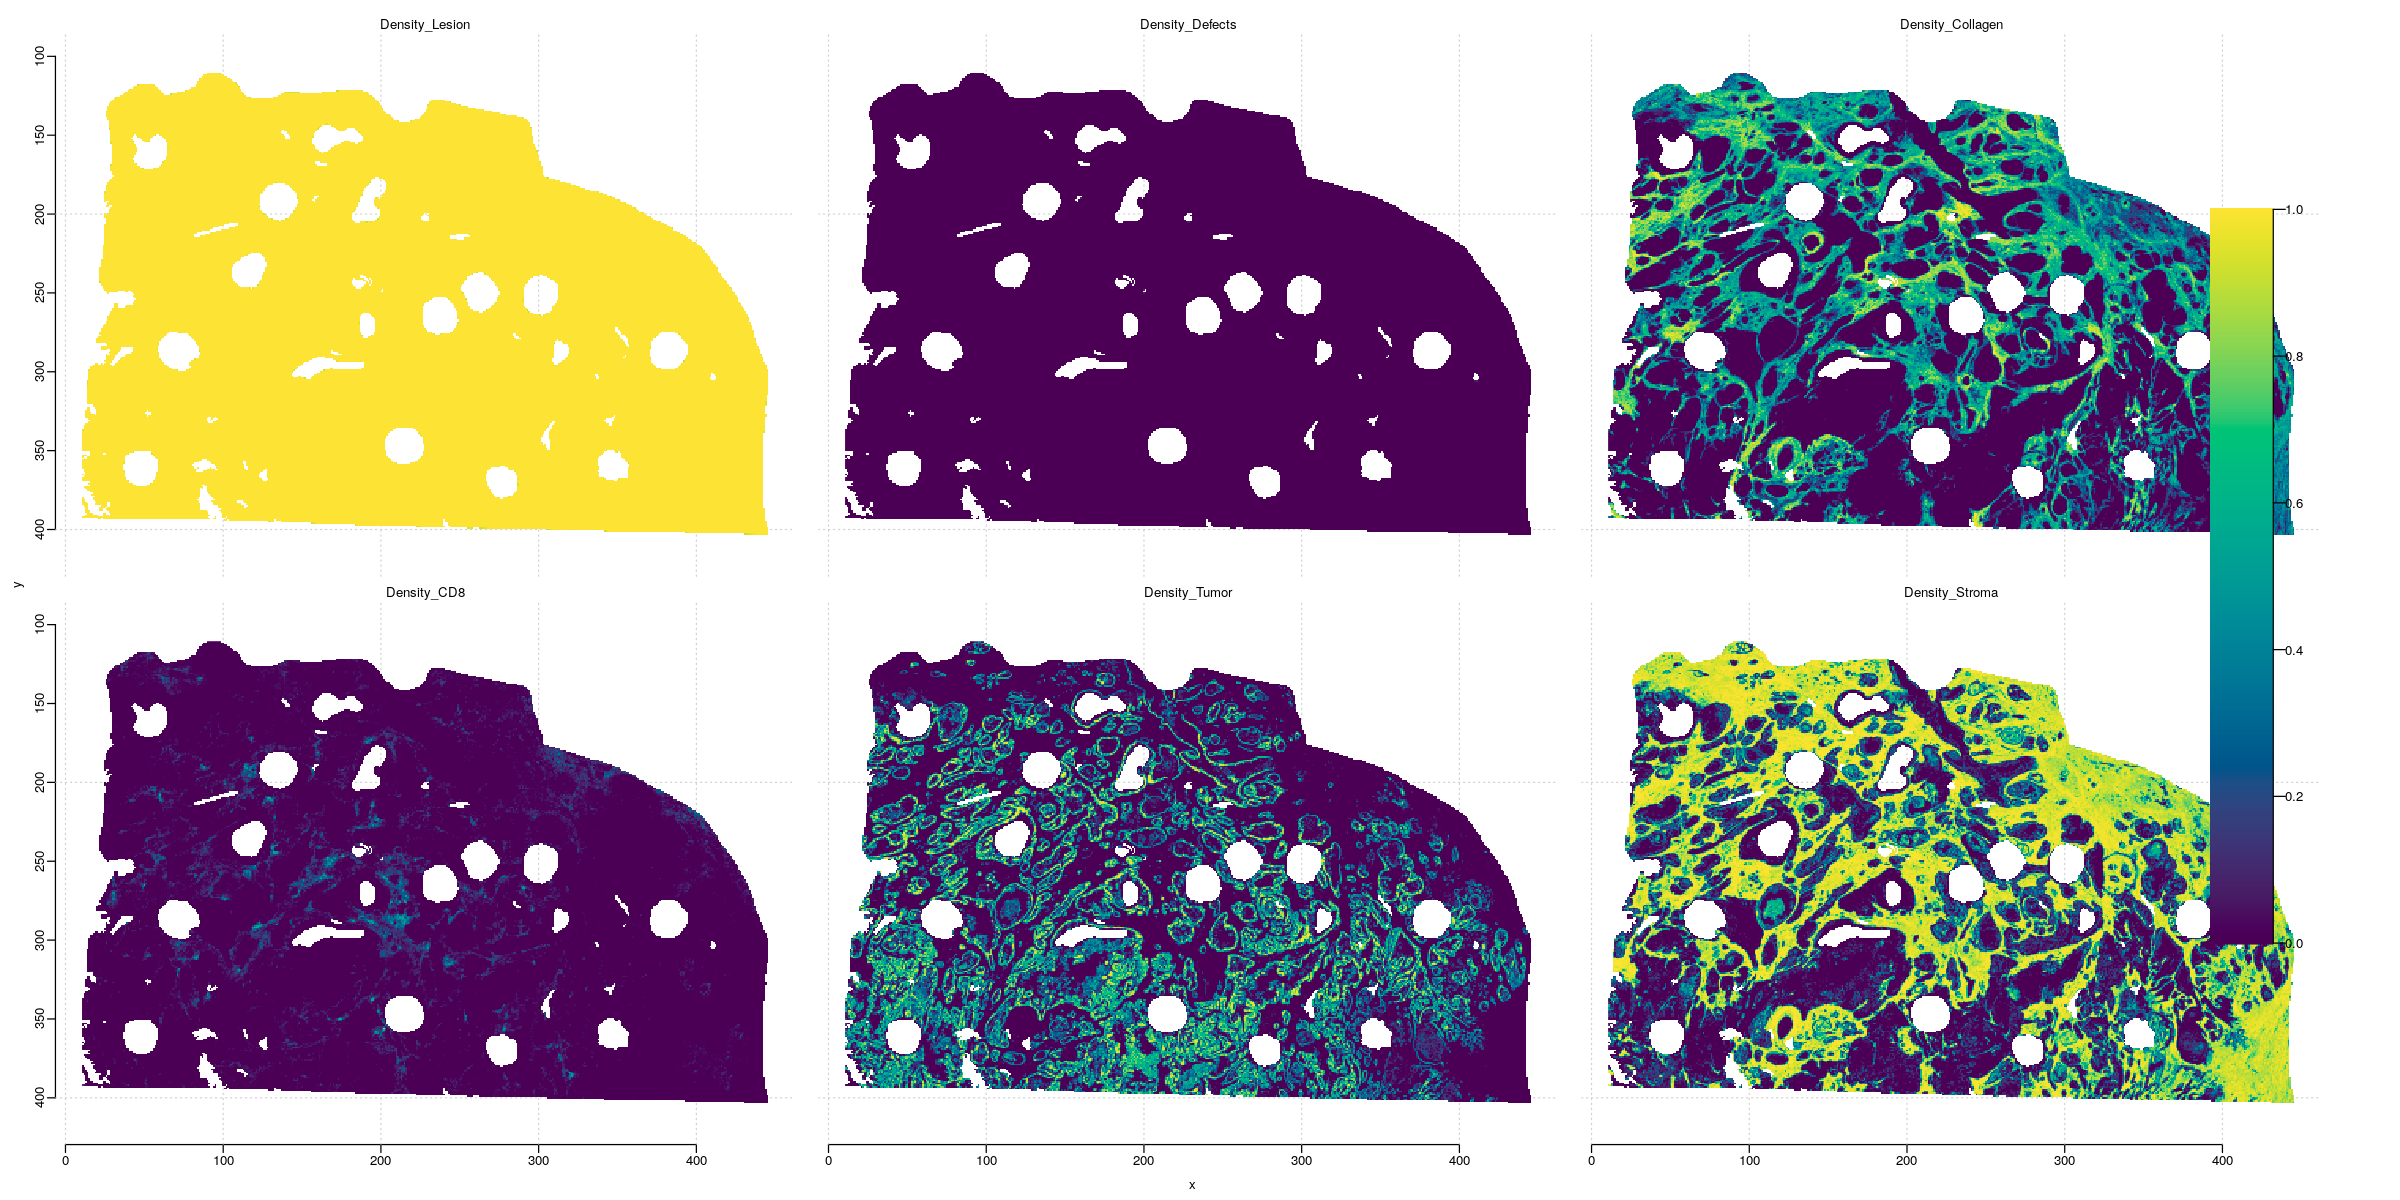

In [36]:
# Visualize the IHC features
options(repr.plot.width = 20, repr.plot.height = 10)
image(mse_subset,
      grep("Density", colnames(pData(mse_subset)), value = TRUE),
      layout = c(2, 3), )

In [38]:
# Compute the percentage of non-zero values in matrix x
x <- spectra(mse_subset) |> as.matrix()
percentage_non_zero <- sum(x != 0) / length(x)
percentage_non_zero

[1] 0.2627623

In [39]:
# Rename the rownames of the matrix x
rownames(x) <- mz(mse_subset)

# save the spectral data as a csv file
write.csv(as.data.frame(t(x)),
          sprintf("%s/results/mse_spectra_region_.csv", path),
          row.names = FALSE)

# Save the pixel data as a csv file
write.csv(as.data.frame(pData(mse_subset)),
          sprintf("%s/results/mse_pixels_region_.csv", path),
          row.names = FALSE)